## Feature Store Fundamentals, Terminology, and Usage

- https://github.com/PacktPublishing/Feature-Store-for-Machine-Learning/blob/main/Chapter03/feast_intro.ipynb

### Introduction to Feast and installation

### Feast terminology and definitions

이 섹션에서는 이러한 용어가 무엇인지 알아봅시다.  
- 엔티티: 엔티티는 의미적으로 관련된 피처의 모음입니다.  
엔티티는 피처를 매핑할 수 있는 도메인 객체입니다.  
차량 호출 서비스에서는 고객과 드라이버가 엔티티가 될 수 있으며, 해당 엔티티로 피처를 그룹화할 수 있습니다.  
다음 코드 블록은 엔티티 정의의 예시입니다:

```python
driver = Entity(name='driver', value_type=ValueType.STRING,
join_key='driver_id')
```

엔티티는 피처 수집 및 검색 프로세스에서 기본 키 역할을 하는 피처 룩업의 일부입니다.  
모델 학습 및 예측 중에 각각 기본 키에서 특정 시점(Point-in-time) 조인 및 피처 조회를 수행할 수 있습니다.

- feature: 피처는 측정 가능한 개별 속성입니다. 일반적으로  피처 엔티티에서 관찰되는 속성이지만 엔티티와 연관될 필요는 없습니다. 예를 들어, 고객이 웹사이트에서 보내는 평균 시간이 피처가 될 수 있습니다. 연관되지 않은 피처는 오늘 웹사이트의 신규 고객 수일 수 있습니다. 다음 코드 블록은 기능 정의의 예입니다:

```python
trips_today = Feature(name="trips_today",
dtype=ValueType.INT64)
```

피처는 기본 피처 데이터의 컬럼을 나타냅니다.  
앞의 예에서 볼 수 있듯이 name 및 dtype 속성이 있습니다.

- Data source: The data source represents the underlying data. Feast supports a range of
data sources including FileSource (local, S3, GCS), BigQuery, and Redshift.
The following screenshot is an example data source:

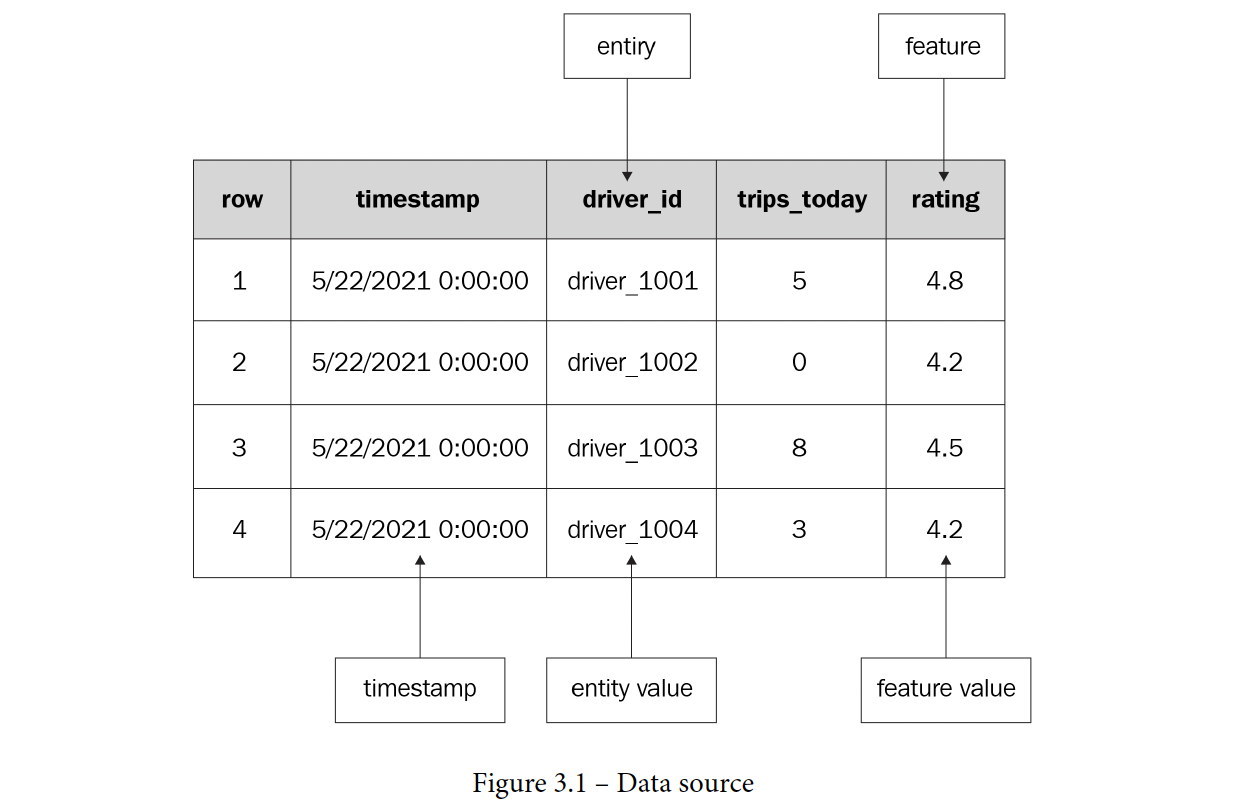

As you can see in the preceding figure, the dataset has a driver_id entity, trips_
today and rating features, and a timestamp column. The structure of the data in the
table you see in Figure 3.1 is a Feature view.

- feature view: 피처뷰는 데이터베이스 테이블과 같으며, 소스에 있는 피처 데이터의 구조를 나타냅니다. 피처 뷰는 엔티티, 하나 이상의 피처, 데이터 소스로 구성됩니다. 피처뷰는 일반적으로 데이터베이스 개체와 유사한 도메인 개체를 중심으로 모델링됩니다. 

피처 뷰에 엔티티가 없는 경우도 있는데, 다음 코드 블록은 피처 뷰 정의의 예입니다:

```python
driver_stats_fv = FeatureView(
name="driver_activity",
entities=["driver"],
ttl=timedelta(hours=2),
features=[
Feature(name="trips_today", dtype=ValueType.INT64),
Feature(name="rating", dtype=ValueType.FLOAT),
],
batch_source=BigQuerySource(
table_ref="feast-oss.demo_data.driver_activity"
)
)
```

앞의 코드 블록에서 볼 수 있듯이 FeatureView에는 driveer 엔티티, trips_today 및 rating feature가 있으며 데이터 소스로는 BigQuerySource가 있습니다.      

피처 스토어에 따라 피처 뷰에는 다른 동의어가 있습니다. 예를 들어, SageMaker FeatureStore에서는 Feature Group이라고 하고, Databricks Feature Store에서는 Feature Table이라고 하며, Feast의 이전 버전에서는 Feature Set 및 Feature Table이라고 합니다.

- Point-in-time joins: 이전 장에서는 모델 재현성과 데이터/예측 문제 디버깅을 위해 시스템 상태를 재현하기 위한 데이터 과학자의 필요성에 대해 설명했습니다. Feast와 다른 피처 스토어에서 데이터는 시계열 레코드로 모델링됩니다. 그림 3.1에서 볼 수 있듯이, 타임스탬프 컬럼은 특정 이벤트가 발생한 시점(즉, 시스템에서 특정 이벤트가 생성된 시점)에 대한 정보를 저장합니다. 이와 함께, 피처 저장소는 생성 시간, 수집 API 호출 시간 등과 같은 추가 열을 추가할 수 있는 유연성을 제공합니다. 이를 통해 데이터 과학자와 데이터 엔지니어는 과거의 어느 때라도 시스템의 상태를 재현할 수 있습니다. 과거의 상태를 재현하기 위해 시스템은 Point-in-time 조인을 수행합니다. Feast에서는 이 기능을 API로 바로 사용할 수 있습니다. 다른 솔루션에서는 사용자가 직접 코드를 작성해야 할 수도 있습니다.

실제로 특정 시점 조인의 예를 살펴보겠습니다.   
다음 데이터 집합에는 그림 3.1에 정의된 FeatureView와 일치하는 스키마가 있습니다.

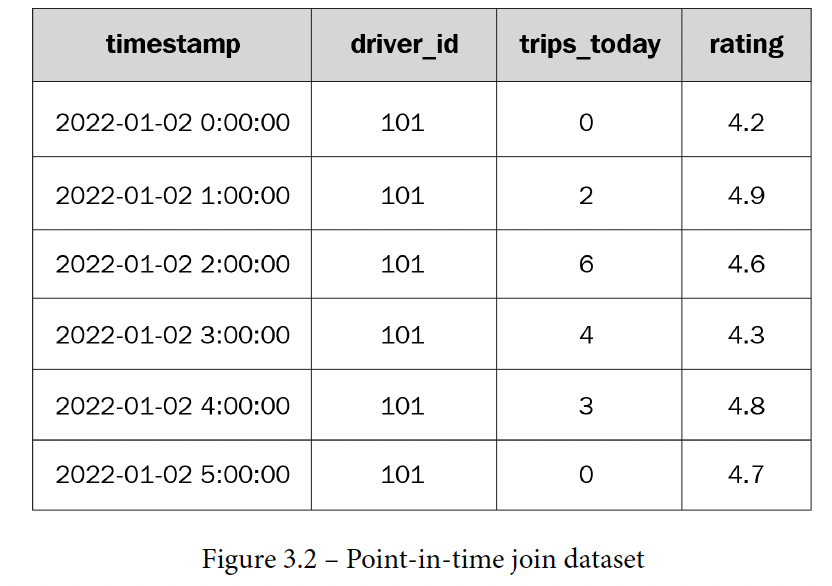

뒷부분에서 살펴보겠지만, 기록 데이터를 가져오려면 다음과 같은 엔티티 DataFrame이 필요합니다:

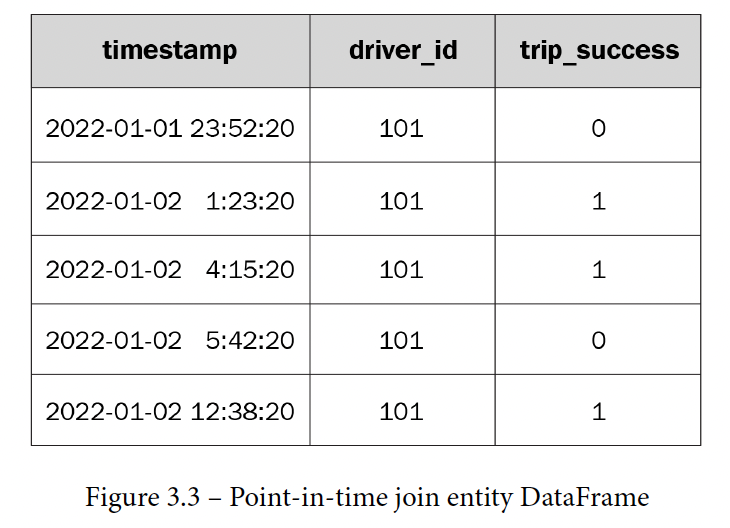

사용자가 그림 3.3의 데이터프레임 엔티티와 피처 목록을 사용하여 store.get_historical_features()를 호출하면 Feast는 point-int-time join을 수행하여 주어진 타임스탬프에서 피처의 최신 값을 가져옵니다.   

예를 들어, 그림 3.3의 첫 번째 행에서 타임스탬프 값은 2022-01-01 23:52:20입니다. point-int-time join은 최신 타임스탬프가 있는 드라이버 피처를 찾습니다.   
다음 스크린샷은 특정 시점 조인이 실제로 작동하는 모습을 보여줍니다:

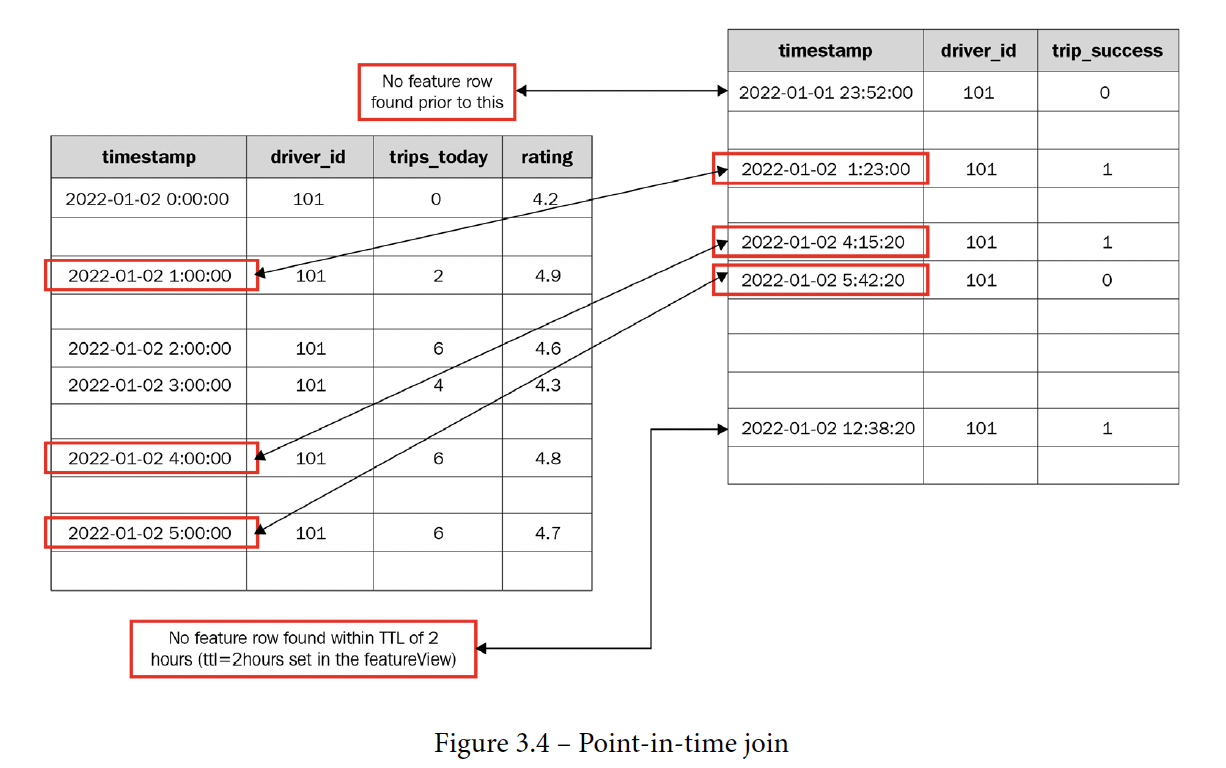

피처뷰에 설정된 실시간 시간(ttl)은 2시간입니다.  
이는 피처가 이벤트가 발생한 시점으로부터 2시간 동안만 살아 있음을 나타냅니다(이벤트_타임스탬프 + 2시간 창).  
point-in-time joins에 대한 로직은 timestamp_in_data >= timestamp_in_entity_dataframe 및 timestamp_in_entity_dataframe <=timestamp_in_data + ttl(2시간)입니다.    
그림 3.4에서 볼 수 있듯이 첫 번째 행은 데이터에 일치하는 기간이 없는 반면, 엔티티 DataFrame의 두 번째, 세 번째 및 네 번째 행은 각각 2022-01-02 1:00:00, 2022-01-01 4:00:00 및 2022-01-01 5:00:00에 발생한 이벤트에 대해 일치하는 기간을 가지고 있습니다.   
동일한 논리에 따라 DataFrame 엔티티의 마지막 행은 데이터에서 일치하는 기간이 없습니다.

The output DataFrame of the point-in-time join is as follows:

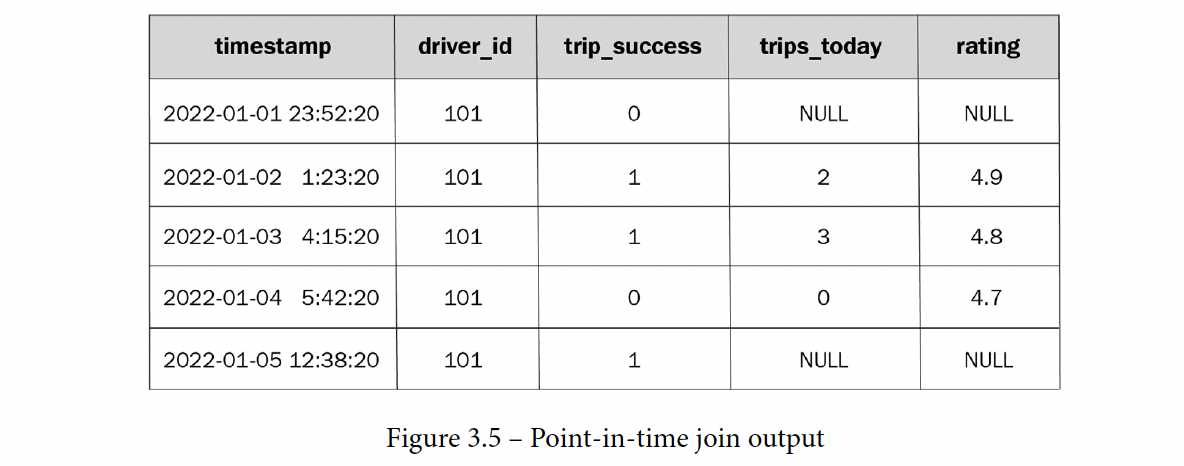

그림 3.5에서 볼 수 있듯이, 일치하는 창이 없는 행의 경우 기능 값이 NULL이고 일치하는 창이 있는 행의 경우 기능을 사용할 수 있습니다.  

다음 섹션에서는 Feast 프로젝트를 초기화하는 방법과 그 내용, 기본적인 API 사용법에 대해 알아보겠습니다.

### Feast initialization

In [1]:
# !pip install Pygments

In [2]:
!pwd

/Users/sguys99/Desktop/project/feast_study/book


In [3]:
!feast init demo


Creating a new Feast repository in /Users/sguys99/Desktop/project/feast_study/book/demo.



In [4]:
!ls -R demo

README.md    __init__.py  feature_repo

demo/feature_repo:
__init__.py        data               feature_store.yaml
__pycache__        example_repo.py    test_workflow.py

demo/feature_repo/__pycache__:
__init__.cpython-310.pyc      test_workflow.cpython-310.pyc
example_repo.cpython-310.pyc

demo/feature_repo/data:
driver_stats.parquet


In [5]:
import pandas as pd

In [6]:
df = pd.read_parquet('demo/feature_repo/data/driver_stats.parquet')

In [7]:
df.head()

,event_timestamp,driver_id,conv_rate,acc_rate,avg_daily_trips,created
0,2024-01-01 14:00:00+00:00,1005,0.936710,0.627883,142,2024-01-16 14:06:32.544
1,2024-01-01 15:00:00+00:00,1005,0.712614,0.365022,33,2024-01-16 14:06:32.544
2,2024-01-01 16:00:00+00:00,1005,0.696993,0.036720,628,2024-01-16 14:06:32.544
3,2024-01-01 17:00:00+00:00,1005,0.685019,0.608909,778,2024-01-16 14:06:32.544
4,2024-01-01 18:00:00+00:00,1005,0.119786,0.951272,560,2024-01-16 14:06:32.544


In [12]:
!pygmentize demo/feature_repo/feature_store.yaml

project: demo
# By default, the registry is a file (but can be turned into a more scalable SQL-backed registry)
registry: data/registry.db
# The provider primarily specifies default offline / online stores & storing the registry in a given cloud
provider: local
online_store:
    type: sqlite
    path: data/online_store.db
entity_key_serialization_version: 2


In [14]:
!pygmentize -f terminal16m demo/feature_repo/example_repo.py

# This is an example feature definition file

from datetime import timedelta

import pandas as pd

from feast import (
    Entity,
    FeatureService,
    FeatureView,
    Field,
    FileSource,
    PushSource,
    RequestSource,
)
from feast.on_demand_feature_view import on_demand_feature_view
from feast.types import Float32, Float64, Int64

# Define an entity for the driver. You can think of an entity as a primary key used to
# fetch features.
driver = Entity(name="driver", join_keys=["driver_id"])

# Read data from parquet files. Parquet is convenient for local development mode. For
# production, you can use your favorite DWH, such as BigQuery. See Feast documentation
# for more info.
driver_stats_source = FileSource(
    name="driver_hourly_stats_source",
    path="/Users/sguys99/Desktop/project/feast_study/book/demo/feature_repo/data/driver_stats.parquet",
    timestamp_field="event_timestamp",
    created_timestamp_column="created",
)

# Our parquet files contain sample data that

In [16]:
%cd demo/feature_repo
!feast apply

[Errno 2] No such file or directory: 'demo/feature_repo'
/Users/sguys99/Desktop/project/feast_study/book/demo/feature_repo
/Users/sguys99/anaconda3/envs/feast_book/lib/python3.10/site-packages/feast/feature_store.py:565: RuntimeWarning: On demand feature view is an experimental feature. This API is stable, but the functionality does not scale well for offline retrieval
  warnings.warn(
Created entity driver
Created feature view driver_hourly_stats_fresh
Created feature view driver_hourly_stats
Created on demand feature view transformed_conv_rate_fresh
Created on demand feature view transformed_conv_rate
Created feature service driver_activity_v3
Created feature service driver_activity_v1
Created feature service driver_activity_v2

Created sqlite table demo_driver_hourly_stats_fresh
Created sqlite table demo_driver_hourly_stats



In [17]:
!ls

__init__.py        data               feature_store.yaml
__pycache__        example_repo.py    test_workflow.py


In [19]:
from feast import FeatureStore

In [20]:
store = FeatureStore(repo_path=".")

In [25]:
for entity in store.list_entities():
    print(entity)

{
  "spec": {
    "name": "driver",
    "joinKey": "driver_id"
  },
  "meta": {
    "createdTimestamp": "2024-01-16T05:14:39.989015Z",
    "lastUpdatedTimestamp": "2024-01-16T05:14:39.989015Z"
  }
}


In [26]:
store.list_feature_views()

[<FeatureView(name = driver_hourly_stats_fresh, entities = ['driver'], ttl = 1 day, 0:00:00, stream_source = {
   "type": "PUSH_SOURCE",
   "name": "driver_stats_push_source",
   "batchSource": {
     "type": "BATCH_FILE",
     "timestampField": "event_timestamp",
     "createdTimestampColumn": "created",
     "fileOptions": {
       "uri": "/Users/sguys99/Desktop/project/feast_study/book/demo/feature_repo/data/driver_stats.parquet"
     },
     "name": "driver_hourly_stats_source"
   }
 }, batch_source = {
   "type": "BATCH_FILE",
   "timestampField": "event_timestamp",
   "createdTimestampColumn": "created",
   "fileOptions": {
     "uri": "/Users/sguys99/Desktop/project/feast_study/book/demo/feature_repo/data/driver_stats.parquet"
   },
   "name": "driver_hourly_stats_source"
 }, entity_columns = [driver_id-Int64], features = [conv_rate-Float32, acc_rate-Float32, avg_daily_trips-Int64], description = , tags = {'team': 'driver_performance'}, owner = , projection = FeatureViewProjecti